In [30]:
import pandas as pd 
import numpy as np
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from google.colab import files
from google.colab import drive
import glob
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import os
!pip install shap
import shap
from skimage.segmentation import slic
from matplotlib.colors import LinearSegmentedColormap
import warnings

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
drive.mount('/content/drive')
uploaded = files.upload()
dataframe = pd.read_csv('benign-and-malignant-images-labels-final.csv')
directory = '/content/drive/MyDrive/ML Project/Retinoblastoma-Project (current)/Data (current)/Benign-and-Malignant-Images'

Mounted at /content/drive


Saving benign-and-malignant-images-labels-final.csv to benign-and-malignant-images-labels-final.csv


In [3]:
image_list = []
for i in range(1, 282):
  filename = directory + "/" + str(i) + ".jpg"
  image = load_img(filename, target_size = (224, 224))
  image_list.append(np.array(image))

In [4]:
for i in range(281): 
    if dataframe['benign_malignant'][i] == "malignant":
        dataframe['benign_malignant'][i] = 1
    elif dataframe['benign_malignant'][i] == "benign":
        dataframe['benign_malignant'][i] = 0
    else:
        dataframe['benign_malignant'][i] = -1

<ipython-input-4-1b4dba39b1f7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['benign_malignant'][i] = 1
<ipython-input-4-1b4dba39b1f7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['benign_malignant'][i] = 0


In [5]:
dataframe['images'] = image_list

In [6]:
dataframeShuffled = shuffle(dataframe)

In [7]:
train_ds, test_ds, train_labels, test_labels = train_test_split(dataframeShuffled['images'].tolist(), dataframeShuffled['benign_malignant'], test_size =  0.33, random_state = 1) 
train_labels = to_categorical(train_labels, num_classes=5)
test_labels = to_categorical(test_labels, num_classes=5)

In [8]:
train_ds = tf.image.resize(train_ds, (224, 224))
test_ds = tf.image.resize(test_ds, (224, 224))

In [9]:
base_model = VGG19(weights="imagenet", include_top=False, input_shape=train_ds[0].shape)
base_model.trainable = False

train_ds = preprocess_input(train_ds) 
test_ds = preprocess_input(test_ds)

80134624/80134624 [==============================] - 3s 0us/step


In [10]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [11]:
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(5, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

In [12]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)


es = EarlyStopping(monitor='val_accuracy', mode='max', patience=15,  restore_best_weights=True)

results = model.fit(train_ds, train_labels, epochs=50, validation_split=0.2, batch_size=32, callbacks=[es]) 

Epoch 1/50
5/5 [==============================] - 166s 35s/step - loss: 2.7990 - accuracy: 0.6667 - val_loss: 0.3545 - val_accuracy: 0.9737
Epoch 2/50
5/5 [==============================] - 166s 35s/step - loss: 2.0223e-04 - accuracy: 1.0000 - val_loss: 0.4057 - val_accuracy: 0.9737
Epoch 3/50
5/5 [==============================] - 152s 31s/step - loss: 5.4498e-06 - accuracy: 1.0000 - val_loss: 0.5248 - val_accuracy: 0.9474
Epoch 4/50
5/5 [==============================] - 162s 34s/step - loss: 1.7246e-07 - accuracy: 1.0000 - val_loss: 0.5650 - val_accuracy: 0.9474
Epoch 5/50
5/5 [==============================] - 160s 33s/step - loss: 1.2508e-06 - accuracy: 1.0000 - val_loss: 0.5907 - val_accuracy: 0.9474
Epoch 6/50
5/5 [==============================] - 167s 36s/step - loss: 2.1185e-06 - accuracy: 1.0000 - val_loss: 0.6070 - val_accuracy: 0.9474
Epoch 7/50
5/5 [==============================] - 162s 34s/step - loss: 2.6595e-06 - accuracy: 1.0000 - val_loss: 0.6173 - val_accuracy: 0.9

(-0.5, 223.5, 223.5, -0.5)

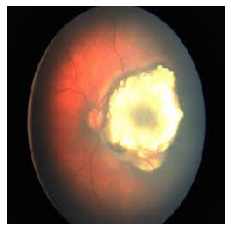

In [21]:
file = directory + "/" + str(5) + ".jpg"
explain_this_image = load_img(file, target_size = (224, 224))
explain_this_image_before = np.array(explain_this_image)
plt.imshow(explain_this_image)
plt.axis('off')

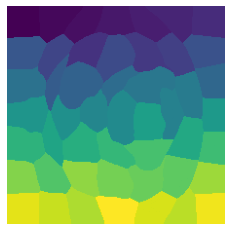

In [31]:
segments_slic = slic(explain_this_image, n_segments=50, compactness=30, sigma=3)
plt.imshow(segments_slic);
plt.axis('off');

In [23]:
def mask_image(zs, segmentation, explain_this_image, background=None):
    if background is None:
        background = explain_this_image.mean((0,1))
    out = np.zeros((zs.shape[0], explain_this_image.shape[0], explain_this_image.shape[1], explain_this_image.shape[2]))
    for i in range(zs.shape[0]):
        out[i,:,:,:] = image
        for j in range(zs.shape[1]):
            if zs[i,j] == 0:
                out[i][segmentation == j,:] = background
    return out
def f(z):
    
    return model.predict(preprocess_input(mask_image(z, segments_slic, explain_this_image_before, 255)))

In [32]:
# use Kernel SHAP to explain the network's predictions
explainer = shap.KernelExplainer(f, np.zeros((1,50)))
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    shap_values = explainer.shap_values(np.ones((1,50)), nsamples=1000)

1/1 [==============================] - 3s 3s/step


  0%|          | 0/1 [00:00<?, ?it/s]

32/32 [==============================] - 850s 26s/step


In [25]:
# get the top predictions from the model
# preds = model.predict(preprocess_input(np.expand_dims(explain_this_image_before.copy(), axis=0)))
#feature_names = [0, 1, 2]
# top_preds = np.argsort(-preds)
# winner = top_preds[0][0]
# score_winner = tf.nn.softmax(preds[0])
# loser = top_preds[0][1]
#score_lower = tf.nn.softmax(preds[1])
# percent_benign = tf.nn.softmax(preds[0])
# percent_malignant = tf.nn.softmax(preds[1])
# percent_other = tf.nn.softmax(top_preds[2])
#top_preds[0].plot(kind = 'bar', title = 'Top Predictions')
#top_3_pred=pd.Series(data={feature_names[str(inds[i])][1]:preds[0, inds[i]] for i in range(3)})
#top_10_pred=pd.Series(data={feature_names[str(inds[i])][1]:preds[0, inds[i]] for i in range(10)})
#top_2_pred=pd.Series(data={feature_names[str(inds[i])][1]:preds[0, inds[i]] for i in range(10)})
#top_3_pred.plot(kind='bar', title='Top 2 Predictions')

1/1 [==============================] - 2s 2s/step


<AxesSubplot:title={'center':'Top 10 Predictions'}>

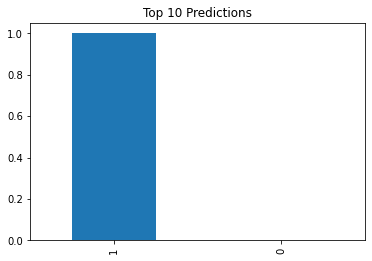

In [26]:
preds = model.predict(preprocess_input(np.expand_dims(explain_this_image_before.copy(), axis=0)))
# feature_names
top_preds = np.argsort(-preds)
inds = top_preds[0]
#top_10_pred=pd.Series(data={feature_names[str(inds[i])][1]:preds[0, inds[i]] for i in range(10)})
top_10_pred=pd.Series(data={str(inds[i]):preds[0, inds[i]] for i in range(2)})
top_10_pred.plot(kind='bar', title='Top 10 Predictions')

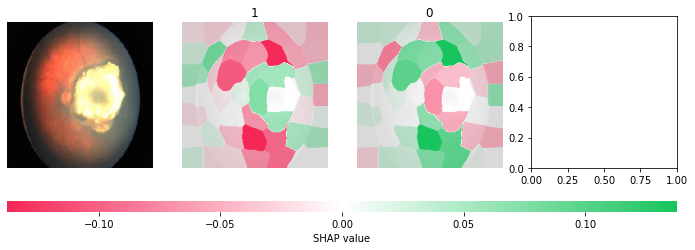

In [33]:
# make a color map
colors = []
for l in np.linspace(1,0,100):
    colors.append((245/255,39/255,87/255,l))
for l in np.linspace(0,1,100):
    colors.append((24/255,196/255,93/255,l))
    
cm = LinearSegmentedColormap.from_list("shap", colors)
# Visualize the explanations
def fill_segmentation(values, segmentation):
    out = np.zeros(segmentation.shape)
    for i in range(len(values)):
        out[segmentation == i] = values[i]
    return out
# plot our explanations
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12,4))
inds = top_preds[0]
axes[0].imshow(explain_this_image)
axes[0].axis('off')
max_val = np.max([np.max(np.abs(shap_values[i][:,:-1])) for i in range(len(shap_values))])
for i in range(2):
    m = fill_segmentation(shap_values[inds[i]][0], segments_slic)
#    axes[i+1].set_title(feature_names[str(inds[i])][1])
    axes[i+1].set_title(str(inds[i]))
    axes[i+1].imshow(explain_this_image.convert('LA'), alpha=0.15)
    im = axes[i+1].imshow(m, cmap=cm, vmin=-max_val, vmax=max_val)
    axes[i+1].axis('off')
cb = fig.colorbar(im, ax=axes.ravel().tolist(), label="SHAP value", orientation="horizontal", aspect=60)
cb.outline.set_visible(False)
plt.show()

In [35]:
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 KB 10.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=7623b35c6d19a4ed05cb2094ca15b58b0dec04f7b28028f55b8fb9cf7680b11a
  Stored in directory: /root/.cache/pip/wheels/ed/d7/c9/5a0130d06d6310bc6cbe55220e6e72dcb8c4eff9a478717066
Successfully built lime


In [36]:
from lime import lime_image

explainer = lime_image.LimeImageExplainer()

In [44]:
explanation = explainer.explain_instance(explain_this_image_before.astype('double'), model.predict,  
                                         top_labels=3, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

(-0.5, 223.5, 223.5, -0.5)

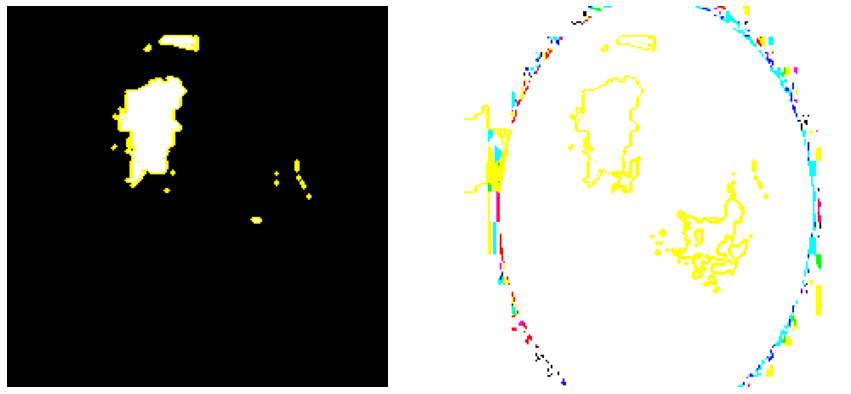

In [41]:
from skimage.segmentation import mark_boundaries

temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')
ax2.axis('off')